# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime

from scipy import signal as fp1
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/19_12_2019_sin_filtrar.npz')
npzfile.files
conjunto_datos_entradasA=npzfile['arr_0']
conjunto_datos_entradasB=npzfile['arr_1']
conjunto_datos_salidas=npzfile['arr_2']
conjunto_datos_eventos=npzfile['arr_3']

## Vamos a rotar todas las imagenes

In [4]:
muestras=conjunto_datos_entradasB.shape[0]
for j in range (1,muestras):
    conjunto_datos_entradasB[j]=np.roll(conjunto_datos_entradasB[j], 45, axis=1)
    conjunto_datos_entradasA[j]=np.roll(conjunto_datos_entradasA[j], 45, axis=1)
    if conjunto_datos_salidas[j,1]<0:
        conjunto_datos_salidas[j,1]=conjunto_datos_salidas[j,1]*180/np.pi+360
    else:
        conjunto_datos_salidas[j,1]=conjunto_datos_salidas[j,1]*180/np.pi

In [5]:

print (muestras)

68002


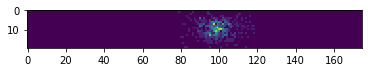

[260146.] 166.5268540564385 200.40955665673982 3.0397541522979736


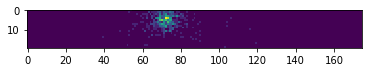

[384568.] 166.3553304649231 145.27818686569464 -30.107128143310547


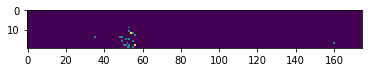

[484749.] 165.4063281353768 129.22711131361405 64.96286010742188


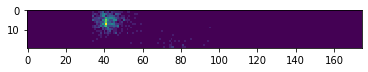

[43303.] 165.77868927271473 156.3991650973688 68.97469329833984


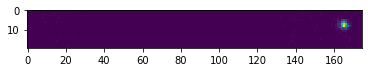

[484749.] 182.91698702649845 336.6917650801031 -13.578989028930664


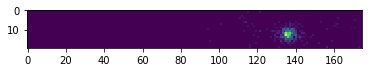

[484749.] 173.05300698963075 278.77326296970193 19.527475357055664


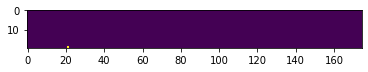

[104721.] 193.17555311349554 40.45224047764407 64.83992767333984


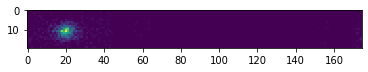

[461096.] 172.8740027867458 38.467624109069675 7.705805778503418


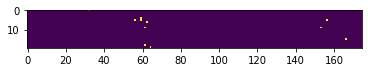

[261309.] 170.24427447401027 201.42237572878602 -13.273375511169434


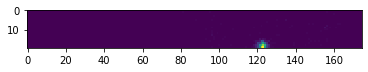

[223893.] 182.37669977908203 249.59993507958643 62.435298919677734


In [6]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos[idea], conjunto_datos_salidas[idea,0],conjunto_datos_salidas[idea,1],conjunto_datos_salidas[idea,2])

## filtro cosas raras por phi

In [7]:
prueba=conjunto_datos_salidas[:,1].reshape(muestras,1)
print(prueba.shape)
veamos4=np.zeros([muestras,175])
indice4=np.zeros([muestras,1])
for i in range(1,muestras):
    veamos4[i]=np.sum(conjunto_datos_entradasB[i], axis=0)
    intermedio4=np.argmax(veamos4[i], axis=0)
    indice4[i]=intermedio4*2.0571428571428



veamos_bad2=np.where(np.logical_and(np.abs(prueba-indice4)>4,np.abs(prueba-indice4)<356 ).all(axis=1) ) 
conjunto_datos_entradasA_filt_bad2=conjunto_datos_entradasA[veamos_bad2]
conjunto_datos_entradasB_filt_bad2=conjunto_datos_entradasB[veamos_bad2]
conjunto_datos_salidas_filt_bad2=conjunto_datos_salidas[veamos_bad2]
conjunto_datos_eventos_filt_bad2=conjunto_datos_eventos[veamos_bad2]
print(conjunto_datos_entradasB_filt_bad2.shape[0])


veamos_good=np.where(np.logical_not(np.logical_and(np.abs(prueba-indice4)>4,np.abs(prueba-indice4)<356 )).all(axis=1) ) 
conjunto_datos_entradasA_filt_good=conjunto_datos_entradasA[veamos_good]
conjunto_datos_entradasB_filt_good=conjunto_datos_entradasB[veamos_good]
conjunto_datos_salidas_filt_good=conjunto_datos_salidas[veamos_good]
conjunto_datos_eventos_filt_good=conjunto_datos_eventos[veamos_good]
print(conjunto_datos_entradasB_filt_good.shape[0])

(68002, 1)
13371
54631


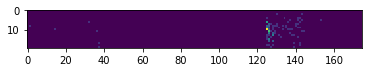

[484749.] 172.92276831211302 244.35573243200457 6.363811492919922


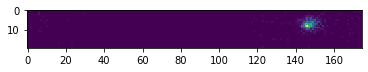

[381779.] 184.69025144764953 295.77484979833105 -11.056166648864746


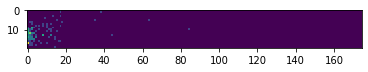

[484749.] 169.6397370956605 346.21493988766184 23.692136764526367


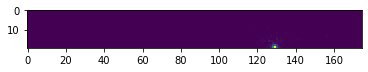

[484749.] 166.19495349042887 260.89608368657304 57.934810638427734


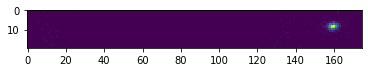

[484749.] 180.15717648883583 320.63249774292444 -7.798760890960693


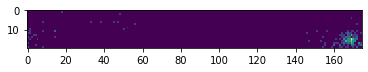

[481823.] 170.1048831137693 343.62956872998876 44.13494110107422


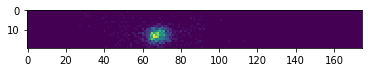

[360548.] 171.5302174388175 140.1930434695913 20.772327423095703


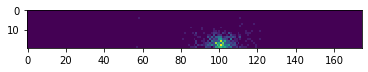

[343869.] 165.5429352602425 202.8763806681098 61.09816360473633


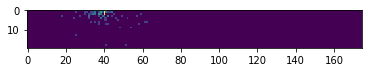

[484749.] 171.38368910454332 77.10113811566839 -66.55831146240234


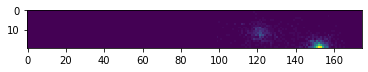

[484749.] 166.64851954122076 249.59011350717276 18.432437896728516


In [8]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_bad2.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_bad2[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_bad2[idea], conjunto_datos_salidas_filt_bad2[idea,0],conjunto_datos_salidas_filt_bad2[idea,1],conjunto_datos_salidas_filt_bad2[idea,2])

## filtro comptom

In [9]:
muestras=conjunto_datos_entradasB_filt_good.shape[0]
conjunto_datos_entradasB_filt_good_rot=np.zeros([muestras,20,175])
for j in range (1,muestras):
    conjunto_datos_entradasB_filt_good_rot[j]=np.roll(conjunto_datos_entradasB_filt_good[j], 10, axis=1)

veamos3_previo=np.zeros([20,175])
veamos3=np.zeros([175])

indices=np.zeros([muestras,1])
for j in range (1,muestras):
    veamos3=np.sum(conjunto_datos_entradasB_filt_good[j], axis=0)
    veamos_peaks = fp1.find_peaks(veamos3, height=40, distance=5)[0]
    indices[j]=veamos_peaks.shape[0]
    veamos3=np.sum(conjunto_datos_entradasB_filt_good_rot[j], axis=0)
    veamos_peaks = fp1.find_peaks(veamos3, height=40, distance=5)[0]
    indices[j]=indices[j]+ veamos_peaks.shape[0]


In [10]:
veamos=np.where((indices>3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_bad3=conjunto_datos_entradasA_filt_good[veamos]

conjunto_datos_entradasB_filt_bad3=conjunto_datos_entradasB_filt_good[veamos]

conjunto_datos_salidas_filt_bad3=conjunto_datos_salidas_filt_good[veamos]
conjunto_datos_eventos_filt_bad3=conjunto_datos_eventos_filt_good[veamos]

In [11]:
print(conjunto_datos_salidas_filt_bad3.shape[0])

2617


In [12]:
veamos=np.where(np.logical_not(indices>3).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_good3=conjunto_datos_entradasA_filt_good[veamos]

conjunto_datos_entradasB_filt_good3=conjunto_datos_entradasB_filt_good[veamos]

conjunto_datos_salidas_filt_good3=conjunto_datos_salidas_filt_good[veamos]
conjunto_datos_eventos_filt_good3=conjunto_datos_eventos_filt_good[veamos]
print(conjunto_datos_salidas_filt_good3.shape[0])

52014


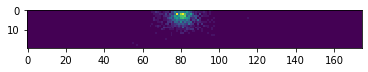

[104258.] 165.29389938751262 162.70506517454956 -47.85041427612305


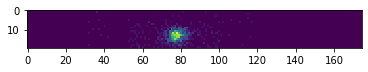

[463071.] 173.20302355625378 156.84456745462947 26.1302490234375


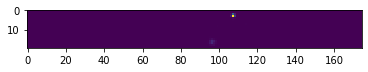

[484749.] 191.06883184250674 217.7639849432367 -47.74986267089844


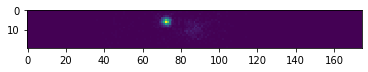

[364234.] 176.32371061994513 145.21961930476027 -26.950481414794922


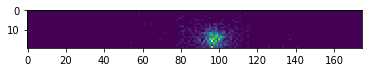

[484749.] 166.397400896915 197.60282096834197 38.33504867553711


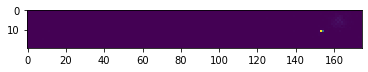

[484749.] 192.689358554429 312.9946058138419 10.365492820739746


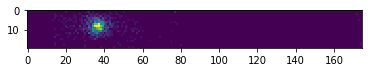

[484749.] 171.38469590593232 72.72649301036746 -8.862420082092285


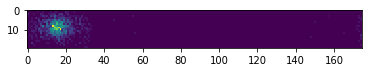

[101346.] 165.60120860835963 28.904895107518556 -4.7501349449157715


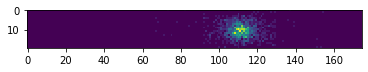

[240166.] 166.17943478648792 226.01102081327585 7.419200897216797


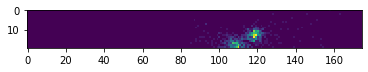

[104119.] 178.54794013122148 241.4042778184675 22.853618621826172


In [13]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_bad3.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_bad3[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_bad3[idea], conjunto_datos_salidas_filt_bad3[idea,0],conjunto_datos_salidas_filt_bad3[idea,1],conjunto_datos_salidas_filt_bad3[idea,2])

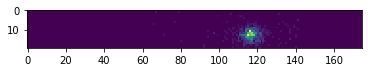

[180527.] 174.3012270627353 237.18039687280552 23.17865753173828


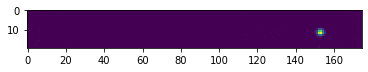

[342297.] 186.47512410991138 311.5497824050153 15.2314453125


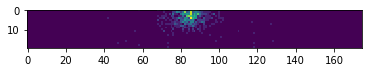

[483995.] 165.31802904894766 171.8546799624966 -46.86491012573242


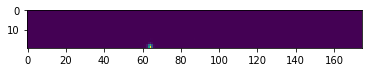

[484749.] 188.2147803899626 128.73803058386127 64.06826782226562


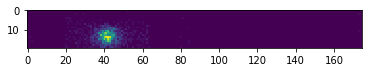

[420020.] 168.0506289131641 82.79741299773603 27.376361846923828


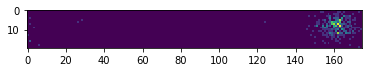

[142628.] 165.04291515597222 329.7119579958591 -10.212827682495117


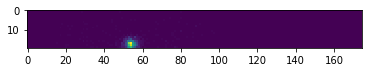

[264500.] 178.92346024479204 107.92207440548498 56.75791549682617


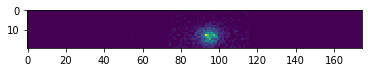

[160336.] 167.97144150855692 192.25550330501164 28.03006935119629


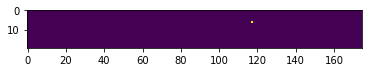

[484749.] 193.7556621497062 238.81570280409437 -22.763378143310547


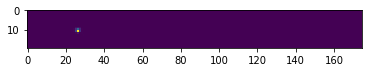

[484749.] 190.7646735348592 50.712002426908214 9.428678512573242


In [14]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB_filt_good3.shape[0])
    plt.imshow(conjunto_datos_entradasB_filt_good3[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_eventos_filt_good3[idea], conjunto_datos_salidas_filt_good3[idea,0],conjunto_datos_salidas_filt_good3[idea,1],conjunto_datos_salidas_filt_good3[idea,2])

In [15]:
    
np.savez('../conjuntos_datos_nuevos_2020/20_12_2019_comptom_filt3',conjunto_datos_entradasA_filt_good3, conjunto_datos_entradasB_filt_good3, conjunto_datos_salidas_filt_good3, conjunto_datos_eventos_filt_good3)

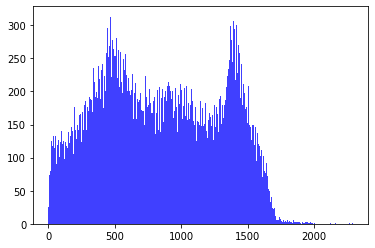

In [16]:
img_rows_t=20
img_cols_t=175
energia1B=conjunto_datos_entradasB_filt_good3.reshape(conjunto_datos_entradasB_filt_good3.shape[0], img_rows_t*img_cols_t)


energia2B=np.sum(energia1B, axis=1)

n1, bins1, patches1=plt.hist(energia2B,400, density=0, facecolor='blue', alpha=0.75)

In [17]:
energia2B_b=energia2B.reshape(energia2B.shape[0],1)


In [20]:
veamos=np.where(np.logical_not(energia2B_b>1250,energia2B_b<1750 ).all(axis=1) )  # & (energia2B_b<1500).all(axis=1))

conjunto_datos_entradasA_filt_good4=conjunto_datos_entradasA_filt_good3[veamos]

conjunto_datos_entradasB_filt_good4=conjunto_datos_entradasB_filt_good3[veamos]

conjunto_datos_eventos_filt_good4=conjunto_datos_eventos_filt_good3[veamos]
conjunto_datos_salidas_filt_good4=conjunto_datos_salidas_filt_good3[veamos]

In [21]:
    
np.savez('../conjuntos_datos_nuevos_2020/29_12_2019_comptom_filt4',conjunto_datos_entradasA_filt_good4, conjunto_datos_entradasB_filt_good4, conjunto_datos_salidas_filt_good4, conjunto_datos_eventos_filt_good4)